<a href="https://colab.research.google.com/github/bhonsleaditya1/Lending-Club-PySpark/blob/master/Lending_Club_Ranking_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gc
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelBinarizer,MinMaxScaler,RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Loading Data

In [ ]:
pdf = pd.read_csv('/content/drive/My Drive/Lending-Club/loanFinal.csv', header=0, escapechar='\\')
#dropcol = pd.read_csv('/content/drive/My Drive/Lending-Club/FinalDrop.csv',header=None)[0].to_list()
dbindex = pd.read_csv('/content/drive/My Drive/Lending-Club/DBRemove.csv')
pdf = pdf[pdf.amnt_left_per<=100]
#pdf = pdf.drop(dropcol,axis=1)
pdf = pdf.drop(dbindex['index'].to_list())
pdf = pdf.reset_index().drop('index',axis=1)
pdf['year'] = pd.DatetimeIndex(pdf['issue_d']).year
reg = pdf.select_dtypes(['float64']).columns
clas = pdf.select_dtypes(['O']).columns
gc.collect()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (41,49,117,118,119,122,123,124,127) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


11

In [ ]:
pdf = pd.read_csv('/content/drive/My Drive/Lending-Club/loanFinal.csv', header=0, escapechar='\\')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (41,49,117,118,119,122,123,124,127) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
def calc_iv(df, feature, target, pr=False):
    """
    Set pr=True to enable printing of output.
    
    Output: 
      * iv: float,
      * data: pandas.DataFrame
    """
    #return feature + str(df[feature].dtype)
    lst = []
    if (str(df[feature].dtype) == 'float64') or (str(df[feature].dtype) == 'int64'):
      #print(feature)
      #print(str(df[feature].dtype))
      #df[feature] = df[feature].fillna(-999999999)
      l = len(pd.qcut(df[feature],q=5,duplicates='drop').value_counts())
      df[feature] = pd.qcut(df[feature],labels=np.arange(l) ,q=5,duplicates='drop')
    else:
      if len(df[feature].unique())>=20:
        return -1,-1
      #else:
        #df[feature] = df[feature].fillna("")
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] != 0)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())


    iv = data['IV'].sum()
    # print(iv)

    return iv, data

In [ ]:
from tqdm import tqdm
columns = pdf.columns.to_list()
j=0
columns.remove('target')
iv={}
data = pd.DataFrame(index=None)
for col in tqdm(pdf.columns):
  #print(calc_iv(pdf[['target',col]],col,'target'))
  i,d = calc_iv(pdf[['target',col]],feature=col,target='target')
  iv[col] = i
  if i == -1:
    j +=1
    continue
  else:
    data =data.append(d)

  1%|          | 1/142 [00:00<00:39,  3.60it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
  9%|▉         | 13/142 [00:13<02:56,  1.36s/it]/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
 99%|█████████▊| 140/142 [01:02<00:00,  3.39it/s]

AttributeError: ignored

In [ ]:
pd.DataFrame(iv.items()).to_excel('IV_pandas.xlsx')

#Ranking Plots 

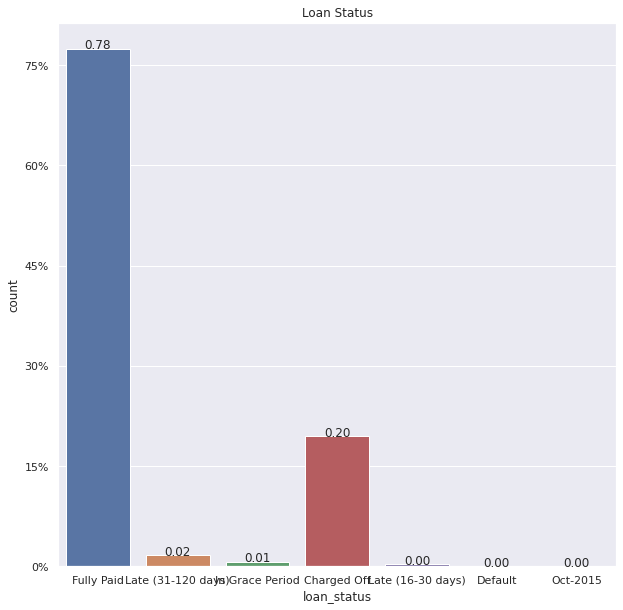

In [ ]:
plt.figure(figsize=[12,10])
sns.set(style="darkgrid")
#titanic = sns.load_dataset("titanic")
total = float(len(pdf['loan_status'])) # one person per row 
#ax = sns.barplot(x="class", hue="who", data=titanic)
ax = sns.countplot(x='loan_status', data=pdf[['loan_status']]) # for Seaborn version 0.7 and more
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=pdf['loan_status'].count()))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
plt.title('Loan Status')
plt.show()

Text(0.5, 1.0, 'Loan Status')

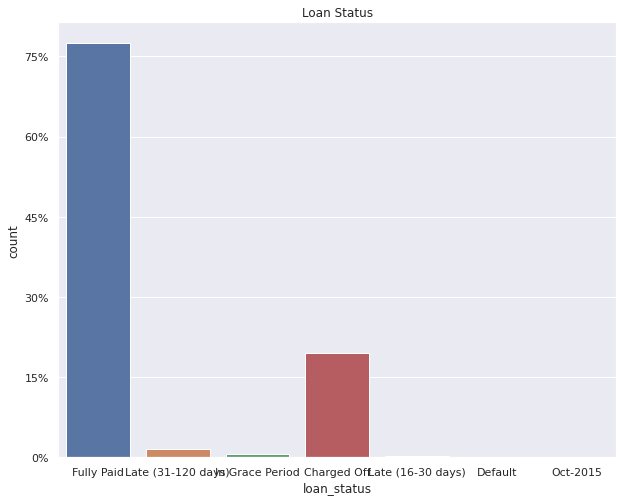

In [ ]:
plt.figure(figsize=[10,8])
sns.set(color_codes=True)
sns.countplot(x='loan_status',data=pdf[['loan_status']])
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=pdf['int_rate'].count()))
plt.title('Loan Status')

In [ ]:
print((y_timetest.target==1).sum()/(y_timetest.target.count()))
print((y_timetest.target==2).sum()/(y_timetest.target.count()))

0.12158804471724505
0.1419510037647922


In [ ]:
print((y_train.target==1).sum()/(y_train.target.count()))
print((y_train.target==2).sum()/(y_train.target.count()))

0.10403809669189
0.10631283119262054


In [ ]:
print((y_test.target==1).sum()/(y_test.target.count()))
print((y_test.target==2).sum()/(y_test.target.count()))

0.10329211825166641
0.10552142166590342


Text(0.5, 0, 'int_rate')

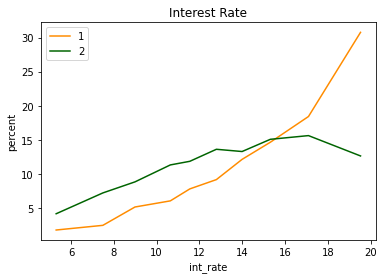

In [ ]:
col = 'int_rate'
pdf['decile'] = pd.qcut(pdf[col],q=10,labels=pd.qcut(x=pdf[col],q=10,retbins=True)[1][:10])
x,y = 'decile','target'
tar =(pdf
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index())
#sns.lineplot(x='decile',y='percent',data=tar[tar.target==0],label='0')
sns.lineplot(x='decile',y='percent',data=tar[tar.target==1],label='1',color='darkorange')
sns.lineplot(x='decile',y='percent',data=tar[tar.target==2],label='2',color='darkgreen')
plt.legend()
plt.title('Interest Rate')
plt.xlabel(col)

In [ ]:
target_0 = pdf[pdf.target==0]
target_1 = pdf[pdf.target==1]
target_2 = pdf[pdf.target==2]

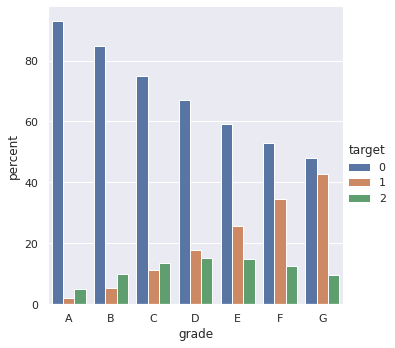

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

x,y = 'grade', 'target'

(pdf
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

Text(0.5, 1.0, 'Grade')

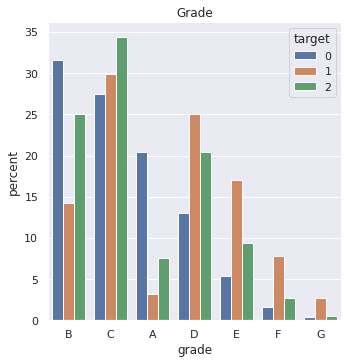

In [ ]:
x,y = 'grade', 'target'
plt.figure(figsize=[8,4.5])
sns.catplot(data=pdf.groupby(y)[x].value_counts(normalize=True).mul(100).rename('percent').reset_index(),x=x,y='percent',hue=y,legend_out=False,kind='bar')
plt.title('Grade')

In [ ]:
t=pdf.groupby(y)[x].value_counts(normalize=True).mul(100).rename('percent').reset_index()

<BarContainer object of 11 artists>

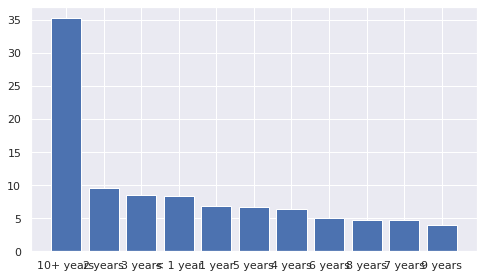

In [ ]:
plt.bar(t[t.target==0][x],t[t.target==0]['percent'])

Text(0.5, 1.0, 'Term')

<Figure size 576x324 with 0 Axes>

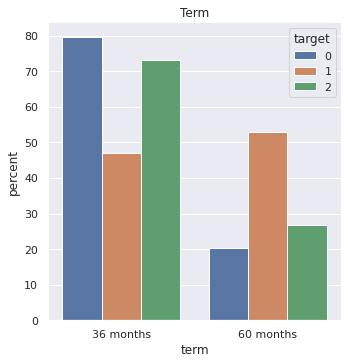

In [ ]:
x,y = 'term', 'target'
plt.figure(figsize=[8,4.5])
sns.set(rc={'figure.figsize':(8,4.5)})
pdf.groupby(y)[x].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',legend_out=False)
plt.title('Term')


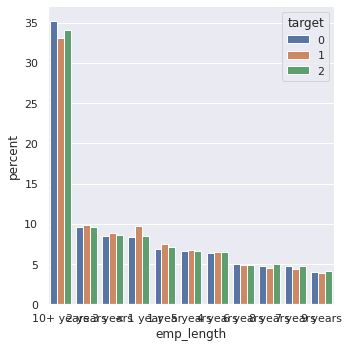

In [ ]:
x,y = 'emp_length', 'target'
#plt.figure(figsize=[8,4.5])
pdf.groupby(y)[x].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',legend_out=False)
#plt.title('Employment Length')

Text(0.5, 1.0, 'Interest Rate')

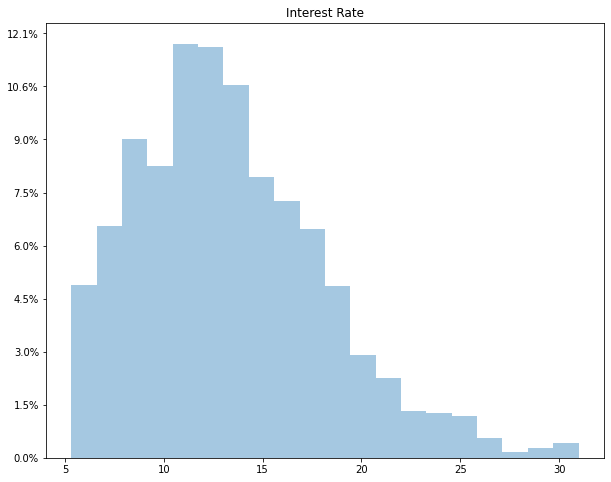

In [ ]:
plt.figure(figsize=[10,8])
sns.distplot(pdf[['int_rate']],bins=20,kde=False,label='')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=pdf['int_rate'].count()))
#plt.legend()

plt.title('Interest Rate')

In [ ]:
target_1_hist=np.histogram(target_1['int_rate'],bins=10,range=(0,27))

Text(0.5, 1.0, 'Interest Rate across classes')

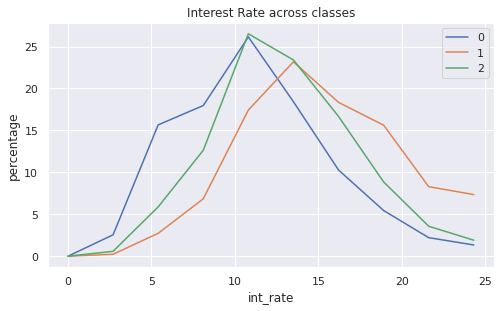

In [ ]:
col='int_rate'
target_0_hist=np.histogram(target_0[col],bins=10,range=(0,27))
target_0_hist=list(target_0_hist)
target_0_hist[0]=target_0_hist[0]*100/np.sum(target_0_hist[0])
target_0_hist=tuple(target_0_hist)
target_1_hist=np.histogram(target_1[col],bins=10,range=(0,27))
target_1_hist=list(target_1_hist)
target_1_hist[0]=target_1_hist[0]*100/np.sum(target_1_hist[0])
target_1_hist=tuple(target_1_hist)
target_2_hist=np.histogram(target_2[col],bins=10,range=(0,27))
target_2_hist=list(target_2_hist)
target_2_hist[0]=target_2_hist[0]*100/np.sum(target_2_hist[0])
target_2_hist=tuple(target_2_hist)
tar_0=pd.DataFrame(target_0_hist).T
plt.figure(figsize=[8,4.5])
tar_0.columns=['percentage',col]
tar_0['label']=0
sns.lineplot(x=tar_0[col],y=tar_0['percentage'],label='0')
tar_1=pd.DataFrame(target_1_hist).T
tar_1.columns=['percentage',col]
tar_1['label']=1
sns.lineplot(x=tar_1[col],y=tar_1['percentage'],label='1')
tar_2=pd.DataFrame(target_2_hist).T
tar_2.columns=['percentage',col]
tar_2['label']=2
sns.lineplot(x=tar_2[col],y=tar_2['percentage'],label='2')
plt.legend()
plt.title('Interest Rate across classes')

In [ ]:
col='int_rate'
target_0_hist=np.histogram(target_0[col],bins=10,range=(0,27))
target_0_hist=list(target_0_hist)
target_0_hist[0]=target_0_hist[0]*100/np.sum(target_0_hist[0])
target_0_hist=tuple(target_0_hist)
target_1_hist=np.histogram(target_1[col],bins=10,range=(0,27))
target_1_hist=list(target_1_hist)
target_1_hist[0]=target_1_hist[0]*100/np.sum(target_1_hist[0])
target_1_hist=tuple(target_1_hist)
target_2_hist=np.histogram(target_2[col],bins=10,range=(0,27))
target_2_hist=list(target_2_hist)
target_2_hist[0]=target_2_hist[0]*100/np.sum(target_2_hist[0])
target_2_hist=tuple(target_2_hist)
tar_0=pd.DataFrame(target_0_hist).T
plt.figure(figsize=[8,4.5])
tar_0.columns=['percentage',col]
tar_0['label']=0
sns.lineplot(x=tar_0[col],y=tar_0['percentage'],label='0')
tar_1=pd.DataFrame(target_1_hist).T
tar_1.columns=['percentage',col]
tar_1['label']=1
sns.lineplot(x=tar_1[col],y=tar_1['percentage'],label='1')
tar_2=pd.DataFrame(target_2_hist).T
tar_2.columns=['percentage',col]
tar_2['label']=2
sns.lineplot(x=tar_2[col],y=tar_2['percentage'],label='2')
plt.legend()
plt.title('Interest Rate across classes')

In [ ]:
pd.qcut(x=pdf[col],q=10,retbins=True,duplicates='drop')[1][:10]

array([  0.,   1.,   2.,   3.,   5., 110.])

Text(0.5, 1.0, '')

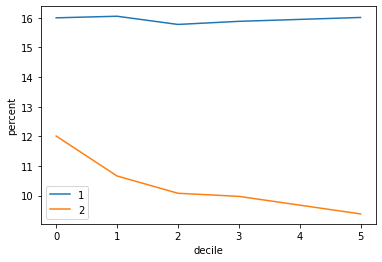

In [ ]:
col = 'total_cu_tl'
li = pd.qcut(x=pdf[col],q=10,retbins=True,duplicates='drop')[1]
l = len(li)
li = li[:l-1]
pdf['decile'] = pd.qcut(pdf[col],q=10,duplicates='drop',labels=li)
x,y = 'decile','target'
tar =(pdf
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index())
#sns.lineplot(x='decile',y='percent',data=tar[tar.target==0],label='0')
sns.lineplot(x='decile',y='percent',data=tar[tar.target==1],label='1')
sns.lineplot(x='decile',y='percent',data=tar[tar.target==2],label='2')
plt.legend()
plt.title('')

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


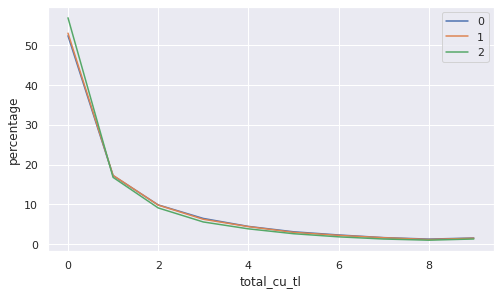

In [ ]:
col='total_cu_tl'
target_0_hist=np.histogram(target_0[col],bins=10,range=(0,10))
target_0_hist=list(target_0_hist)
target_0_hist[0]=target_0_hist[0]*100/np.sum(target_0_hist[0])
target_0_hist=tuple(target_0_hist)
target_1_hist=np.histogram(target_1[col],bins=10,range=(0,10))
target_1_hist=list(target_1_hist)
target_1_hist[0]=target_1_hist[0]*100/np.sum(target_1_hist[0])
target_1_hist=tuple(target_1_hist)
target_2_hist=np.histogram(target_2[col],bins=10,range=(0,10))
target_2_hist=list(target_2_hist)
target_2_hist[0]=target_2_hist[0]*100/np.sum(target_2_hist[0])
target_2_hist=tuple(target_2_hist)
tar_0=pd.DataFrame(target_0_hist).T
plt.figure(figsize=[8,4.5])
tar_0.columns=['percentage',col]
tar_0['label']=0
sns.lineplot(x=tar_0[col],y=tar_0['percentage'],label='0')
tar_1=pd.DataFrame(target_1_hist).T
tar_1.columns=['percentage',col]
tar_1['label']=1
sns.lineplot(x=tar_1[col],y=tar_1['percentage'],label='1')
tar_2=pd.DataFrame(target_2_hist).T
tar_2.columns=['percentage',col]
tar_2['label']=2
sns.lineplot(x=tar_2[col],y=tar_2['percentage'],label='2')
plt.legend()

Text(0.5, 0, 'open_il_24m')

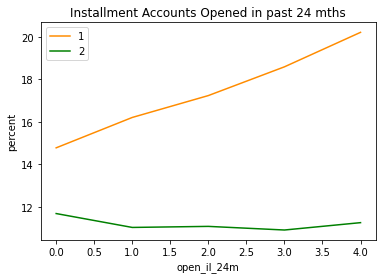

In [ ]:
col = 'open_il_24m'
li = pd.qcut(x=pdf[col],q=10,retbins=True,duplicates='drop')[1]
l = len(li)
li = li[:l-1]
pdf['decile'] = pd.qcut(pdf[col],q=10,duplicates='drop',labels=li)
x,y = 'decile','target'
tar =(pdf
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index())
#sns.lineplot(x='decile',y='percent',data=tar[tar.target==0],label='0')
sns.lineplot(x='decile',y='percent',data=tar[tar.target==1],label='1',color='darkorange')
sns.lineplot(x='decile',y='percent',data=tar[tar.target==2],label='2',color='green')
plt.legend()
plt.title('Installment Accounts Opened in past 24 mths')
plt.xlabel(col)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Installment Accounts Opened in past 24 mths')

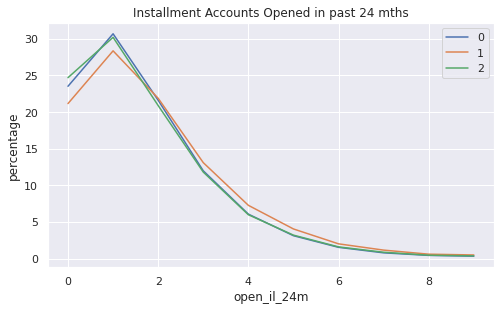

In [ ]:
col='open_il_24m'
lim=10
bins=10
target_0_hist=np.histogram(target_0[col],bins=bins,range=(0,lim))
target_0_hist=list(target_0_hist)
target_0_hist[0]=target_0_hist[0]*100/np.sum(target_0_hist[0])
target_0_hist=tuple(target_0_hist)
target_1_hist=np.histogram(target_1[col],bins=bins,range=(0,lim))
target_1_hist=list(target_1_hist)
target_1_hist[0]=target_1_hist[0]*100/np.sum(target_1_hist[0])
target_1_hist=tuple(target_1_hist)
target_2_hist=np.histogram(target_2[col],bins=bins,range=(0,lim))
target_2_hist=list(target_2_hist)
target_2_hist[0]=target_2_hist[0]*100/np.sum(target_2_hist[0])
target_2_hist=tuple(target_2_hist)
tar_0=pd.DataFrame(target_0_hist).T
plt.figure(figsize=[8,4.5])
tar_0.columns=['percentage',col]
tar_0['label']=0
sns.lineplot(x=tar_0[col],y=tar_0['percentage'],label='0')
tar_1=pd.DataFrame(target_1_hist).T
tar_1.columns=['percentage',col]
tar_1['label']=1
sns.lineplot(x=tar_1[col],y=tar_1['percentage'],label='1')
tar_2=pd.DataFrame(target_2_hist).T
tar_2.columns=['percentage',col]
tar_2['label']=2
sns.lineplot(x=tar_2[col],y=tar_2['percentage'],label='2')
plt.legend()
plt.title('Installment Accounts Opened in past 24 mths')

Text(0.5, 0, 'all_util')

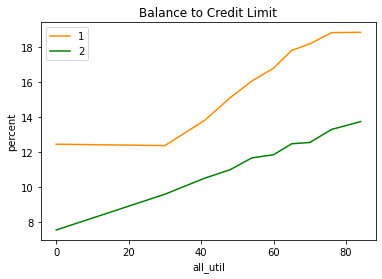

In [ ]:
col = 'all_util'
li = pd.qcut(x=pdf[col],q=10,retbins=True,duplicates='drop')[1]
l = len(li)
li = li[:l-1]
pdf['decile'] = pd.qcut(pdf[col],q=10,duplicates='drop',labels=li)
x,y = 'decile','target'
tar =(pdf
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index())
#sns.lineplot(x='decile',y='percent',data=tar[tar.target==0],label='0')
sns.lineplot(x='decile',y='percent',data=tar[tar.target==1],label='1',color='darkorange')
sns.lineplot(x='decile',y='percent',data=tar[tar.target==2],label='2',color='green')
plt.legend()
plt.title('Balance to Credit Limit')
plt.xlabel(col)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Balance to Credit Limit')

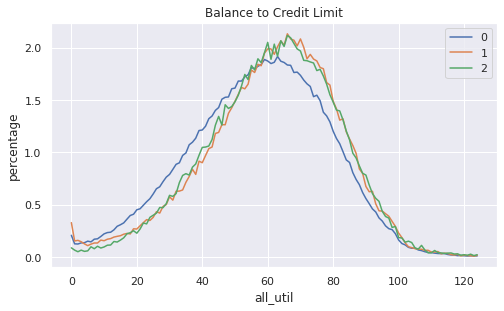

In [ ]:
col='all_util'
lim=125
bins=125
target_0_hist=np.histogram(target_0[col],bins=bins,range=(0,lim))
target_0_hist=list(target_0_hist)
target_0_hist[0]=target_0_hist[0]*100/np.sum(target_0_hist[0])
target_0_hist=tuple(target_0_hist)
target_1_hist=np.histogram(target_1[col],bins=bins,range=(0,lim))
target_1_hist=list(target_1_hist)
target_1_hist[0]=target_1_hist[0]*100/np.sum(target_1_hist[0])
target_1_hist=tuple(target_1_hist)
target_2_hist=np.histogram(target_2[col],bins=bins,range=(0,lim))
target_2_hist=list(target_2_hist)
target_2_hist[0]=target_2_hist[0]*100/np.sum(target_2_hist[0])
target_2_hist=tuple(target_2_hist)
tar_0=pd.DataFrame(target_0_hist).T
plt.figure(figsize=[8,4.5])
tar_0.columns=['percentage',col]
tar_0['label']=0
sns.lineplot(x=tar_0[col],y=tar_0['percentage'],label='0')
tar_1=pd.DataFrame(target_1_hist).T
tar_1.columns=['percentage',col]
tar_1['label']=1
sns.lineplot(x=tar_1[col],y=tar_1['percentage'],label='1')
tar_2=pd.DataFrame(target_2_hist).T
tar_2.columns=['percentage',col]
tar_2['label']=2
sns.lineplot(x=tar_2[col],y=tar_2['percentage'],label='2')
plt.legend()
plt.title('Balance to Credit Limit')

Text(0.5, 0, 'acc_open_past_24mths')

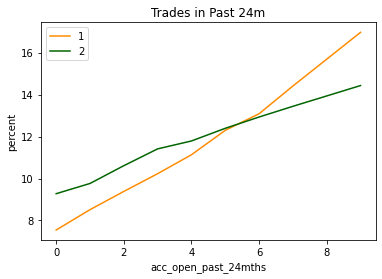

In [ ]:
col = 'acc_open_past_24mths'
li = pd.qcut(x=pdf[col],q=10,retbins=True,duplicates='drop')[1]
l = len(li)
li = li[:l-1]
pdf['decile'] = pd.qcut(pdf[col],q=10,duplicates='drop',labels=li)
x,y = 'decile','target'
tar =(pdf
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index())
#sns.lineplot(x='decile',y='percent',data=tar[tar.target==0],label='0')
sns.lineplot(x='decile',y='percent',data=tar[tar.target==1],label='1',color='darkorange')
sns.lineplot(x='decile',y='percent',data=tar[tar.target==2],label='2',color='darkgreen')
plt.legend()
plt.title('Trades in Past 24m')
plt.xlabel(col)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Trades in Past 24m')

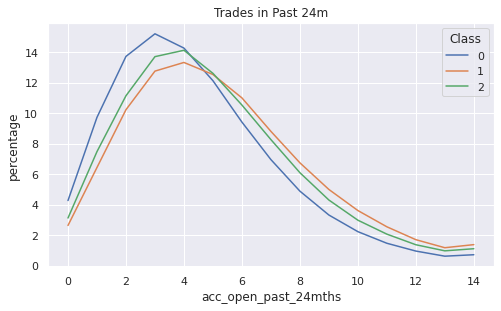

In [ ]:
col='acc_open_past_24mths'
lim=15
bins=15
target_0_hist=np.histogram(target_0[col],bins=bins,range=(0,lim))
target_0_hist=list(target_0_hist)
target_0_hist[0]=target_0_hist[0]*100/np.sum(target_0_hist[0])
target_0_hist=tuple(target_0_hist)
target_1_hist=np.histogram(target_1[col],bins=bins,range=(0,lim))
target_1_hist=list(target_1_hist)
target_1_hist[0]=target_1_hist[0]*100/np.sum(target_1_hist[0])
target_1_hist=tuple(target_1_hist)
target_2_hist=np.histogram(target_2[col],bins=bins,range=(0,lim))
target_2_hist=list(target_2_hist)
target_2_hist[0]=target_2_hist[0]*100/np.sum(target_2_hist[0])
target_2_hist=tuple(target_2_hist)
tar_0=pd.DataFrame(target_0_hist).T
plt.figure(figsize=[8,4.5])
tar_0.columns=['percentage',col]
tar_0['label']=0
sns.lineplot(x=tar_0[col],y=tar_0['percentage'],label='0')
tar_1=pd.DataFrame(target_1_hist).T
tar_1.columns=['percentage',col]
tar_1['label']=1
sns.lineplot(x=tar_1[col],y=tar_1['percentage'],label='1')
tar_2=pd.DataFrame(target_2_hist).T
tar_2.columns=['percentage',col]
tar_2['label']=2
sns.lineplot(x=tar_2[col],y=tar_2['percentage'],label='2')
plt.legend(title='Class')
plt.title('Trades in Past 24m')

Text(0.5, 1.0, 'Trades in Past 24m')

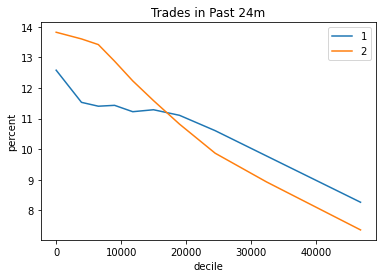

In [ ]:
col = 'total_bc_limit'
li = pd.qcut(x=pdf[col],q=10,retbins=True,duplicates='drop')[1]
l = len(li)
li = li[:l-1]
pdf['decile'] = pd.qcut(pdf[col],q=10,duplicates='drop',labels=li)
x,y = 'decile','target'
tar =(pdf
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index())
#sns.lineplot(x='decile',y='percent',data=tar[tar.target==0],label='0')
sns.lineplot(x='decile',y='percent',data=tar[tar.target==1],label='1')
sns.lineplot(x='decile',y='percent',data=tar[tar.target==2],label='2')
plt.legend()
plt.title('Trades in Past 24m')

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Trades in Past 24m')

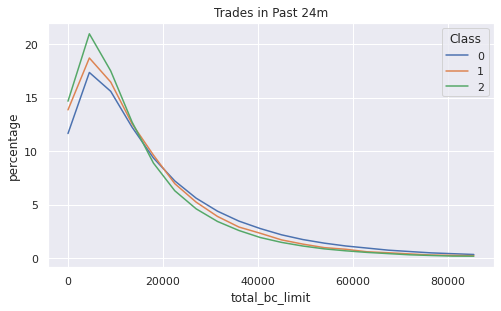

In [ ]:
col='total_bc_limit'
lim=90000
bins=20
target_0_hist=np.histogram(target_0[col],bins=bins,range=(0,lim))
target_0_hist=list(target_0_hist)
target_0_hist[0]=target_0_hist[0]*100/np.sum(target_0_hist[0])
target_0_hist=tuple(target_0_hist)
target_1_hist=np.histogram(target_1[col],bins=bins,range=(0,lim))
target_1_hist=list(target_1_hist)
target_1_hist[0]=target_1_hist[0]*100/np.sum(target_1_hist[0])
target_1_hist=tuple(target_1_hist)
target_2_hist=np.histogram(target_2[col],bins=bins,range=(0,lim))
target_2_hist=list(target_2_hist)
target_2_hist[0]=target_2_hist[0]*100/np.sum(target_2_hist[0])
target_2_hist=tuple(target_2_hist)
tar_0=pd.DataFrame(target_0_hist).T
plt.figure(figsize=[8,4.5])
tar_0.columns=['percentage',col]
tar_0['label']=0
sns.lineplot(x=tar_0[col],y=tar_0['percentage'],label='0')
tar_1=pd.DataFrame(target_1_hist).T
tar_1.columns=['percentage',col]
tar_1['label']=1
sns.lineplot(x=tar_1[col],y=tar_1['percentage'],label='1')
tar_2=pd.DataFrame(target_2_hist).T
tar_2.columns=['percentage',col]
tar_2['label']=2
sns.lineplot(x=tar_2[col],y=tar_2['percentage'],label='2')
plt.legend(title='Class')
plt.title('Trades in Past 24m')

Text(0.5, 0, 'tot_hi_cred_lim')

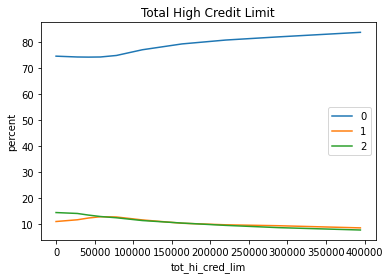

In [ ]:
col = 'tot_hi_cred_lim'
li = pd.qcut(x=pdf[col],q=10,retbins=True,duplicates='drop')[1]
l = len(li)
li = li[:l-1]
pdf['decile'] = pd.qcut(pdf[col],q=10,duplicates='drop',labels=li)
x,y = 'decile','target'
tar =(pdf
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index())
sns.lineplot(x='decile',y='percent',data=tar[tar.target==0],label='0')
sns.lineplot(x='decile',y='percent',data=tar[tar.target==1],label='1')
sns.lineplot(x='decile',y='percent',data=tar[tar.target==2],label='2')
plt.legend()
plt.title('Total High Credit Limit')
plt.xlabel(col)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Total High Credit Limit')

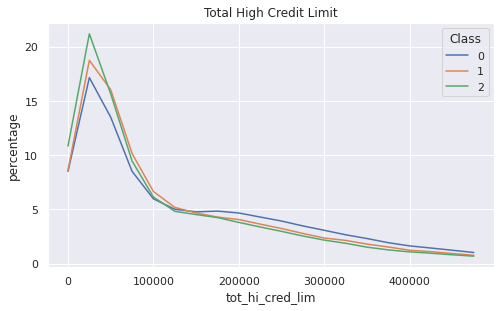

In [ ]:
col='tot_hi_cred_lim'
lim=500000
bins=20
target_0_hist=np.histogram(target_0[col],bins=bins,range=(0,lim))
target_0_hist=list(target_0_hist)
target_0_hist[0]=target_0_hist[0]*100/np.sum(target_0_hist[0])
target_0_hist=tuple(target_0_hist)
target_1_hist=np.histogram(target_1[col],bins=bins,range=(0,lim))
target_1_hist=list(target_1_hist)
target_1_hist[0]=target_1_hist[0]*100/np.sum(target_1_hist[0])
target_1_hist=tuple(target_1_hist)
target_2_hist=np.histogram(target_2[col],bins=bins,range=(0,lim))
target_2_hist=list(target_2_hist)
target_2_hist[0]=target_2_hist[0]*100/np.sum(target_2_hist[0])
target_2_hist=tuple(target_2_hist)
tar_0=pd.DataFrame(target_0_hist).T
plt.figure(figsize=[8,4.5])
tar_0.columns=['percentage',col]
tar_0['label']=0
sns.lineplot(x=tar_0[col],y=tar_0['percentage'],label='0')
tar_1=pd.DataFrame(target_1_hist).T
tar_1.columns=['percentage',col]
tar_1['label']=1
sns.lineplot(x=tar_1[col],y=tar_1['percentage'],label='1')
tar_2=pd.DataFrame(target_2_hist).T
tar_2.columns=['percentage',col]
tar_2['label']=2
sns.lineplot(x=tar_2[col],y=tar_2['percentage'],label='2')
plt.legend(title='Class')
plt.title('Total High Credit Limit')